In [123]:
import cv2
import os
from tqdm import tqdm 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [124]:
def loading_the_data(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            
            filepaths.append(fpath)
            labels.append(fold)

    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)
    
    return df


# Loading the training data

In [125]:
data_dir = r'C:\Users\krrah\Downloads\archive (15)\train'
train_df = loading_the_data(data_dir)

train_df

,filepaths,labels
0,C:\Users\krrah\Downloads\archive (15)\train\be...,benign
1,C:\Users\krrah\Downloads\archive (15)\train\be...,benign
2,C:\Users\krrah\Downloads\archive (15)\train\be...,benign
3,C:\Users\krrah\Downloads\archive (15)\train\be...,benign
4,C:\Users\krrah\Downloads\archive (15)\train\be...,benign
...,...,...
2632,C:\Users\krrah\Downloads\archive (15)\train\ma...,malignant
2633,C:\Users\krrah\Downloads\archive (15)\train\ma...,malignant
2634,C:\Users\krrah\Downloads\archive (15)\train\ma...,malignant
2635,C:\Users\krrah\Downloads\archive (15)\train\ma...,malignant


# Loading the testing data

In [126]:

data_dir = r'C:\Users\krrah\Downloads\archive (15)\test'
ts_df = loading_the_data(data_dir)

ts_df

,filepaths,labels
0,C:\Users\krrah\Downloads\archive (15)\test\ben...,benign
1,C:\Users\krrah\Downloads\archive (15)\test\ben...,benign
2,C:\Users\krrah\Downloads\archive (15)\test\ben...,benign
3,C:\Users\krrah\Downloads\archive (15)\test\ben...,benign
4,C:\Users\krrah\Downloads\archive (15)\test\ben...,benign
...,...,...
655,C:\Users\krrah\Downloads\archive (15)\test\mal...,malignant
656,C:\Users\krrah\Downloads\archive (15)\test\mal...,malignant
657,C:\Users\krrah\Downloads\archive (15)\test\mal...,malignant
658,C:\Users\krrah\Downloads\archive (15)\test\mal...,malignant


# Data Preprocessing

In [127]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_datagen():
    train_datagen = ImageDataGenerator(
        rescale=1./255,  # Normalize pixel values
        rotation_range=15,  # Random rotations
        horizontal_flip=True,  # Random horizontal flips
        zoom_range=0.1  # Random zoom
    )

    # For testing, only rescaling is needed
    test_datagen = ImageDataGenerator(rescale=1./255)

    return train_datagen, test_datagen

def load_data_with_generator(train_dir, test_dir, img_size=64, batch_size=32):
    train_datagen, test_datagen = create_datagen()

    # Create a training data generator
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary' 
    )

    # Create a testing data generator
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary' 
    )

    return train_generator, test_generator

# Define your directories
train_dir = r'C:\Users\krrah\Downloads\archive (15)\train'
test_dir = r'C:\Users\krrah\Downloads\archive (15)\test'

train_generator, test_generator = load_data_with_generator(train_dir, test_dir)



Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


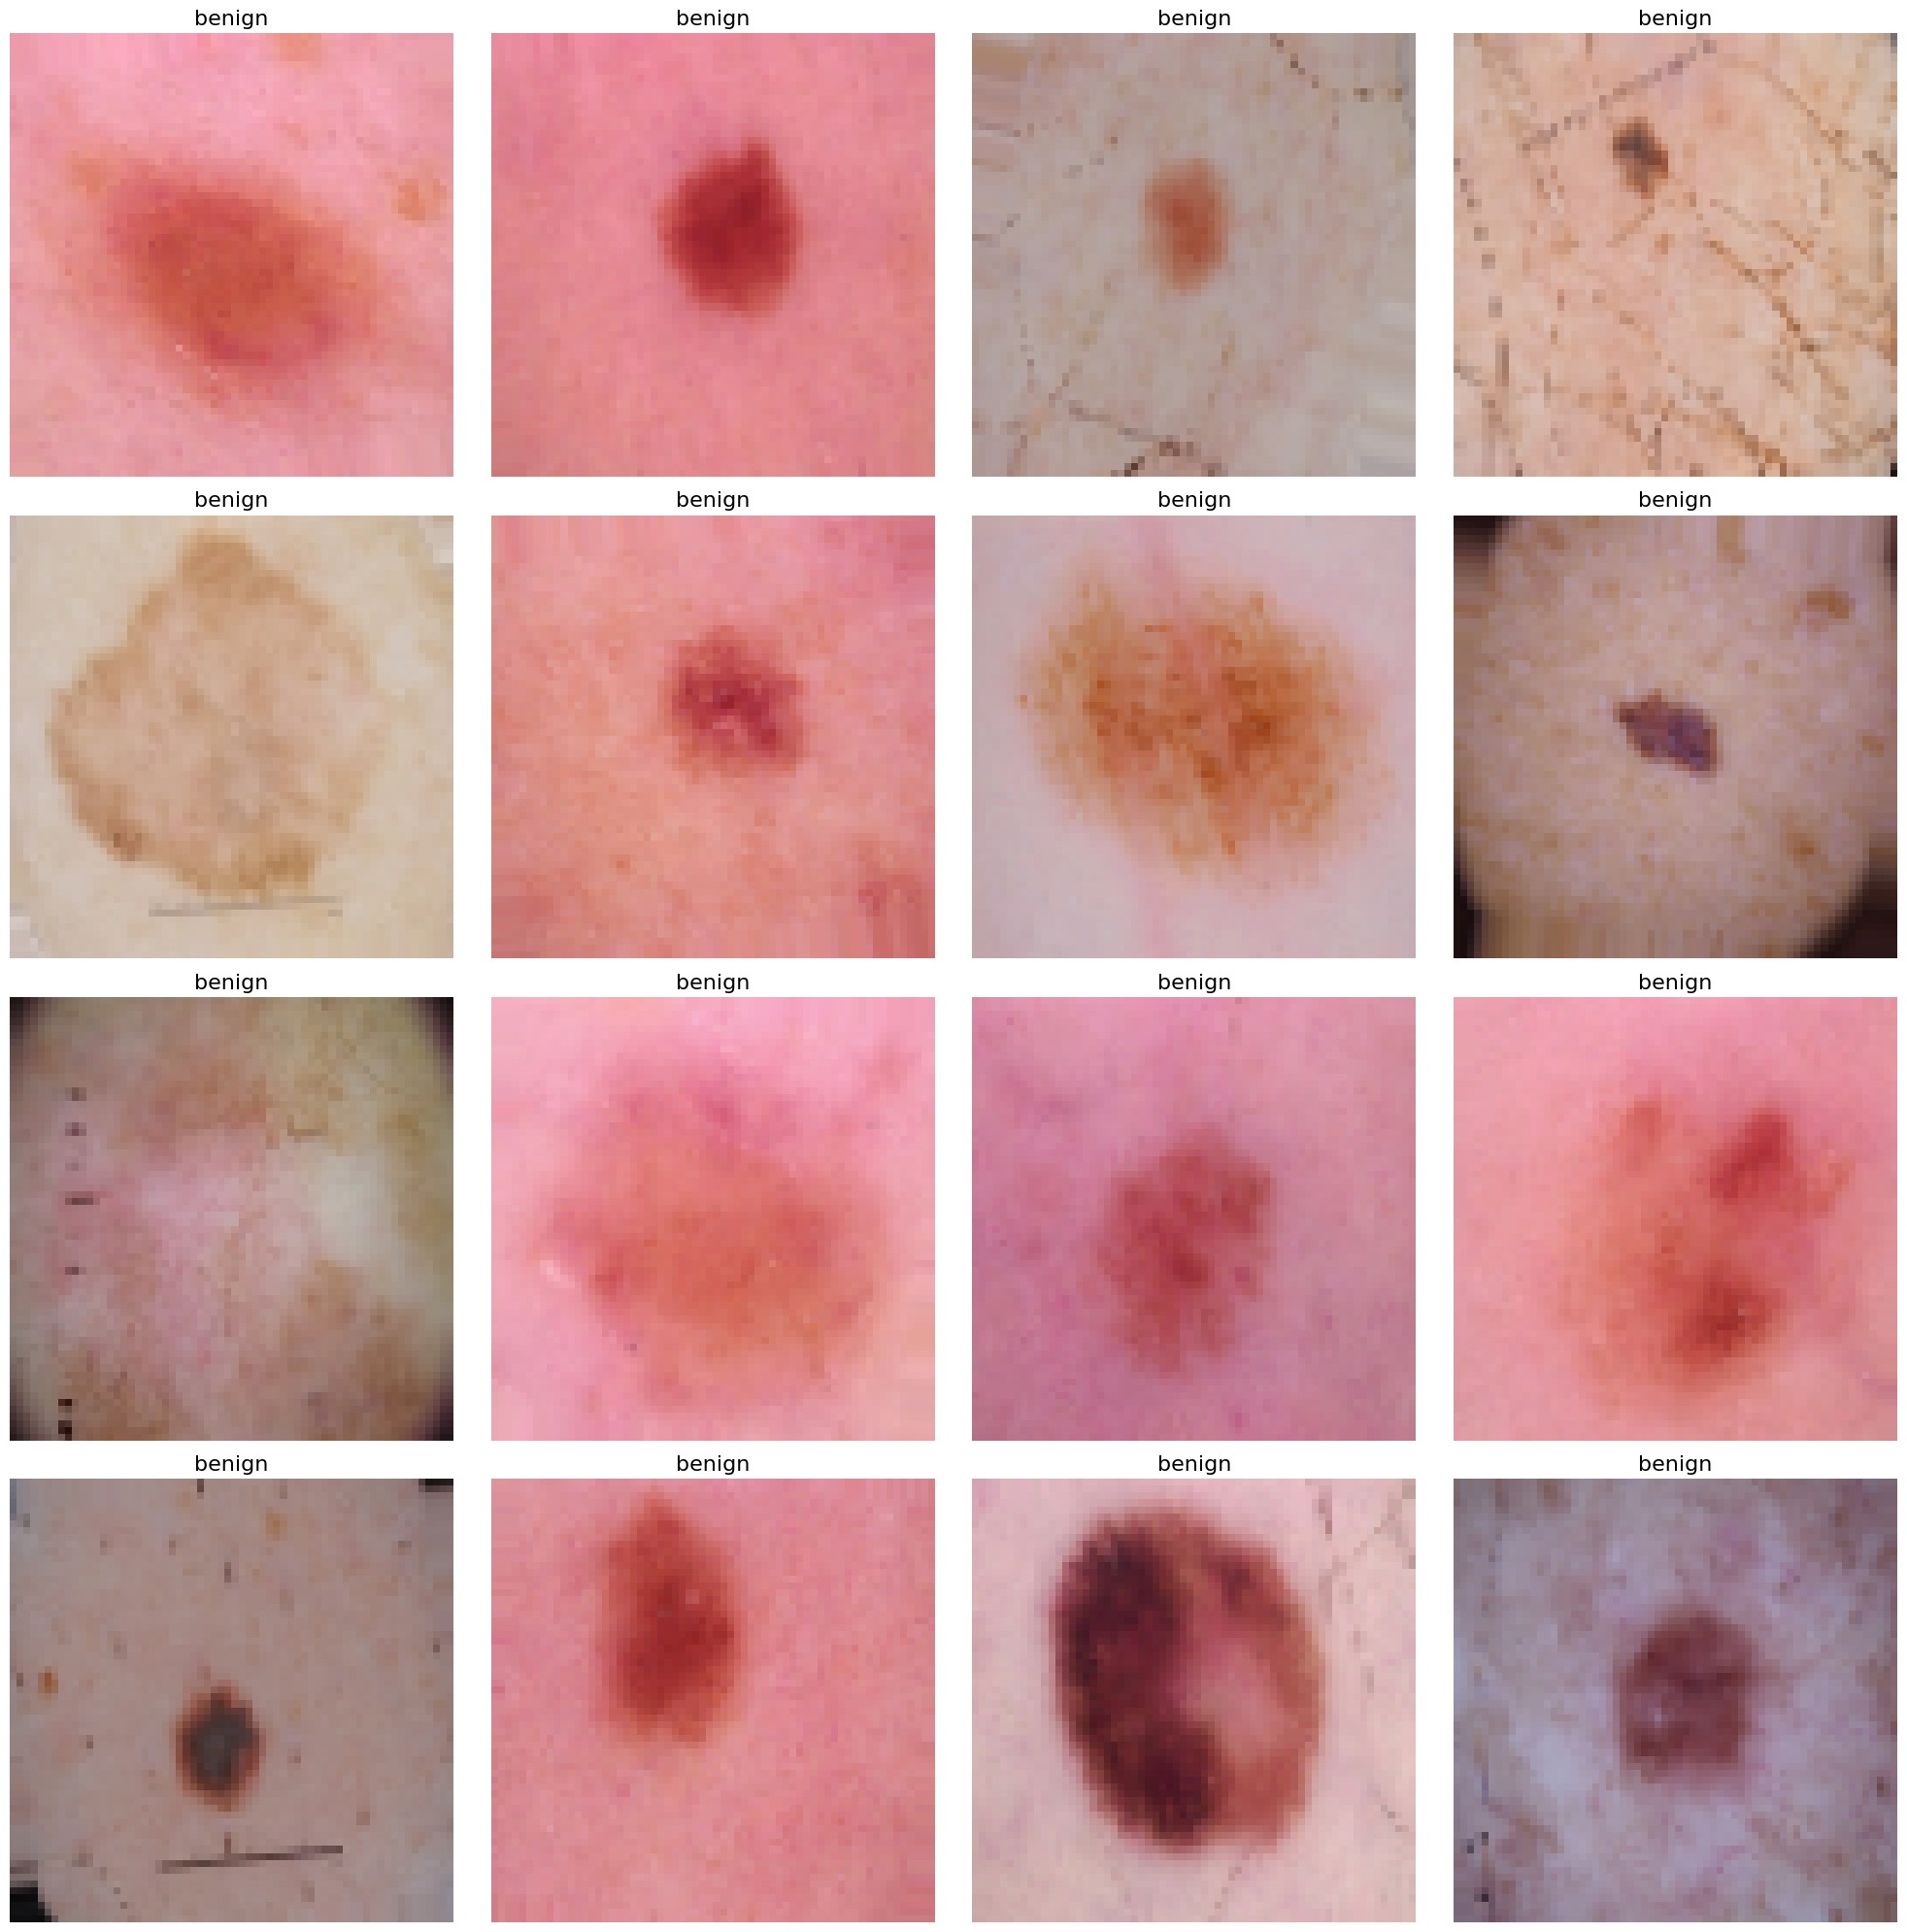

In [128]:
def display_sample_images(generator):
    """
    Display a batch of images from a data generator.
    """
    images, labels = next(generator)  
    classes = list(generator.class_indices.keys())  
    
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        index = np.argmax(labels[i]) 
        class_name = classes[index]
        plt.title(class_name, color='black', fontsize=16)
        plt.axis('off')
        if i == 15:  
            break
    plt.tight_layout()
    plt.show()

display_sample_images(train_generator)


# Build Custom CNN

In [129]:
def build_custom_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')
    ])
    return model

custom_cnn_model = build_custom_cnn((64, 64, 3), 1)

custom_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

custom_cnn_model.summary()

c:\Users\krrah\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,176,385 (4.49 MB)

 Trainable params: 1,176,385 (4.49 MB)

 Non-trainable params: 0 (0.00 B)

In [130]:
history_custom_cnn = custom_cnn_model.fit(
    train_generator, 
    validation_data=test_generator, 
    epochs=10,  
    batch_size=32)  

Epoch 1/10


c:\Users\krrah\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.5564 - loss: 0.6580 - val_accuracy: 0.7379 - val_loss: 0.5045
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 0.7445 - loss: 0.5243 - val_accuracy: 0.6970 - val_loss: 0.5306
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - accuracy: 0.7538 - loss: 0.4862 - val_accuracy: 0.7470 - val_loss: 0.4667
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 0.7697 - loss: 0.4637 - val_accuracy: 0.7955 - val_loss: 0.4239
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.7971 - loss: 0.4285 - val_accuracy: 0.8106 - val_loss: 0.3815
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - accuracy: 0.8157 - loss: 0.3856 - val_accuracy: 0.5470 - val_loss: 0.6593
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.7586 - loss: 0.4620 - val_accuracy: 0.8061 - val_loss: 0.3689
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.7972 - loss: 0.4026 - val_accuracy: 0.762

In [131]:
test_loss, test_acc = custom_cnn_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8029 - loss: 0.4093
Test accuracy: 0.8060606122016907, Test loss: 0.42962783575057983


In [132]:
test_generator.reset() 
predictions_custom_cnn = custom_cnn_model.predict(test_generator)
predicted_classes_custom_cnn = (predictions_custom_cnn > 0.5).astype(int)
true_classes = test_generator.classes

print("Custom CNN Model Evaluation")
print(classification_report(true_classes, predicted_classes_custom_cnn))

fpr, tpr, thresholds = roc_curve(true_classes, predictions_custom_cnn)
roc_auc = auc(fpr, tpr)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Custom CNN Model Evaluation
              precision    recall  f1-score   support

           0       0.55      0.40      0.46       360
           1       0.45      0.60      0.52       300

    accuracy                           0.49       660
   macro avg       0.50      0.50      0.49       660
weighted avg       0.50      0.49      0.49       660



# VGG16 Model

In [133]:
def build_vgg16_model(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')
    ])

    return model

vgg16_model = build_vgg16_model((64, 64, 3), 1)

vgg16_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

vgg16_model.summary()


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [134]:
history_vgg16 = vgg16_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10, 
    batch_size=32  
)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 43s 495ms/step - accuracy: 0.7172 - loss: 0.5859 - val_accuracy: 0.8106 - val_loss: 0.4095
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 488ms/step - accuracy: 0.8106 - loss: 0.4271 - val_accuracy: 0.8152 - val_loss: 0.3859
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 44s 523ms/step - accuracy: 0.8160 - loss: 0.4170 - val_accuracy: 0.8167 - val_loss: 0.3725
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 44s 526ms/step - accuracy: 0.8366 - loss: 0.3539 - val_accuracy: 0.8045 - val_loss: 0.3987
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 44s 525ms/step - accuracy: 0.8088 - loss: 0.3901 - val_accuracy: 0.8303 - val_loss: 0.3556
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 44s 529ms/step - accuracy: 0.8483 - loss: 0.3512 - val_accuracy: 0.8379 - val_loss: 0.3475
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 44s 529ms/step - accuracy: 0.8415 - loss: 0.3516 - val_accuracy: 0.8182 - val_loss: 0.3781
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 44s 527ms/step - accuracy: 0.8161 - loss: 0.3721 - val_accu

In [135]:
test_loss, test_acc = vgg16_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 408ms/step - accuracy: 0.8468 - loss: 0.3554
Test accuracy: 0.8454545736312866, Test loss: 0.3354488015174866


In [136]:
test_generator.reset()  
predictions_vgg16 = vgg16_model.predict(test_generator)
predicted_classes_vgg16 = (predictions_vgg16 > 0.5).astype(int)

print("VGG16 Model Evaluation")
print(classification_report(true_classes, predicted_classes_vgg16))

fpr_vgg16, tpr_vgg16, thresholds_vgg16 = roc_curve(true_classes, predictions_vgg16)
roc_auc_vgg16 = auc(fpr_vgg16, tpr_vgg16)

21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 401ms/step
VGG16 Model Evaluation
              precision    recall  f1-score   support

           0       0.51      0.47      0.49       360
           1       0.41      0.45      0.43       300

    accuracy                           0.46       660
   macro avg       0.46      0.46      0.46       660
weighted avg       0.46      0.46      0.46       660



# Build the VGG19 Model

In [137]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import models, layers

def build_vgg19_model(input_shape, num_classes):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')
    ])

    return model

vgg19_model = build_vgg19_model((64, 64, 3), 1)

vgg19_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 50s 1us/step


In [138]:
history_vgg19 = vgg19_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,  
    batch_size=32  
)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 54s 633ms/step - accuracy: 0.6828 - loss: 0.6115 - val_accuracy: 0.7939 - val_loss: 0.4248
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 54s 641ms/step - accuracy: 0.7839 - loss: 0.4588 - val_accuracy: 0.7818 - val_loss: 0.4733
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 53s 634ms/step - accuracy: 0.7787 - loss: 0.4392 - val_accuracy: 0.8212 - val_loss: 0.3700
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 53s 630ms/step - accuracy: 0.8159 - loss: 0.3919 - val_accuracy: 0.8318 - val_loss: 0.3624
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 57s 679ms/step - accuracy: 0.7971 - loss: 0.4235 - val_accuracy: 0.7985 - val_loss: 0.4207
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 64s 763ms/step - accuracy: 0.8191 - loss: 0.3826 - val_accuracy: 0.8409 - val_loss: 0.3512
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 58s 694ms/step - accuracy: 0.8098 - loss: 0.4103 - val_accuracy: 0.8561 - val_loss: 0.3429
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 50s 601ms/step - accuracy: 0.8300 - loss: 0.3799 - val_accu

In [144]:
test_loss, test_acc = vgg19_model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 298ms/step - accuracy: 0.8405 - loss: 0.3263
Test accuracy: 0.8409090638160706, Test loss: 0.33688926696777344


In [139]:
test_generator.reset()  
predictions_vgg19 = vgg19_model.predict(test_generator)
predicted_classes_vgg19 = (predictions_vgg19 > 0.5).astype(int)


21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 476ms/step


In [140]:
print("VGG19 Model Evaluation")
print(classification_report(true_classes, predicted_classes_vgg19))

fpr_vgg19, tpr_vgg19, thresholds_vgg19 = roc_curve(true_classes, predictions_vgg19)
roc_auc_vgg19 = auc(fpr_vgg19, tpr_vgg19)

VGG19 Model Evaluation
              precision    recall  f1-score   support

           0       0.54      0.56      0.55       360
           1       0.45      0.43      0.44       300

    accuracy                           0.50       660
   macro avg       0.50      0.50      0.50       660
weighted avg       0.50      0.50      0.50       660



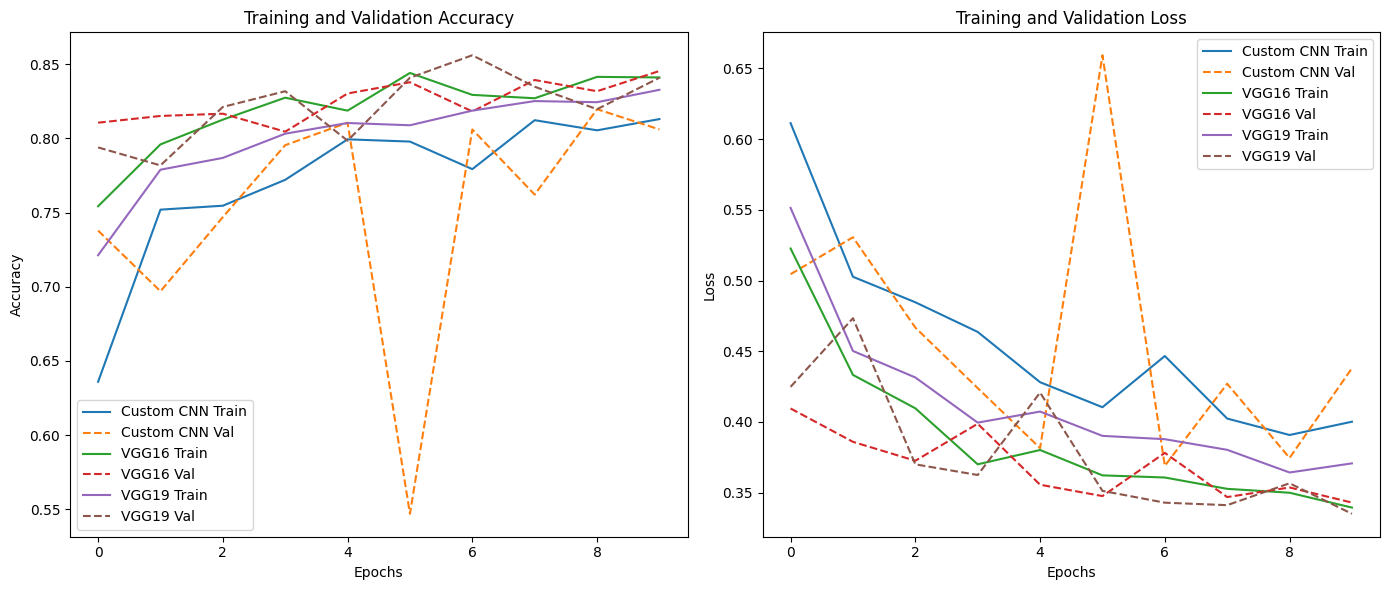

In [141]:
def plot_model_history(model_histories, labels, metric='accuracy'):
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    for history, label in zip(model_histories, labels):
        plt.plot(history.history[metric], label=f'{label} Train')
        plt.plot(history.history[f'val_{metric}'], '--', label=f'{label} Val')
    plt.title(f'Training and Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()

    plt.subplot(1, 2, 2)
    for history, label in zip(model_histories, labels):
        plt.plot(history.history['loss'], label=f'{label} Train')
        plt.plot(history.history['val_loss'], '--', label=f'{label} Val')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_model_history(
    [history_custom_cnn, history_vgg16, history_vgg19],
    ['Custom CNN', 'VGG16', 'VGG19']
)

Custom CNN Model Confusion Matrix


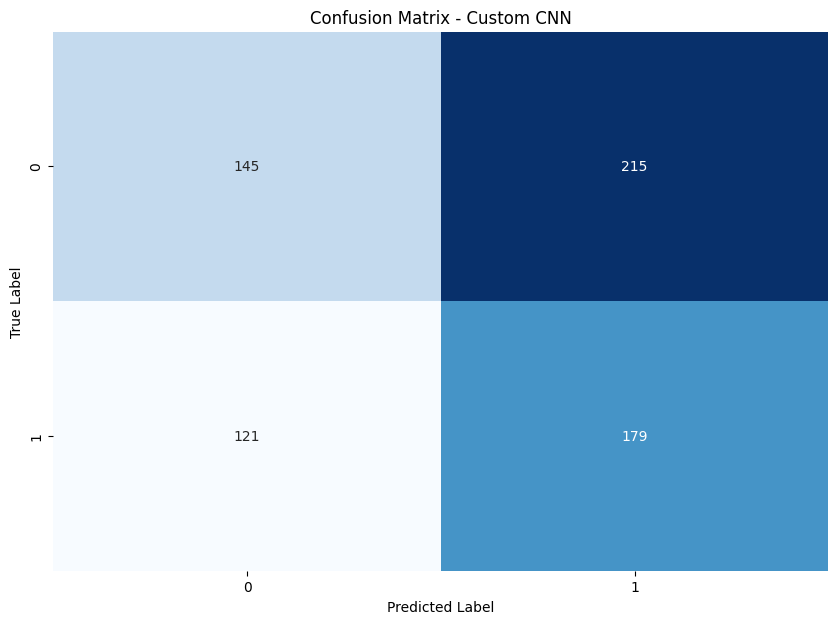

VGG16 Model Confusion Matrix


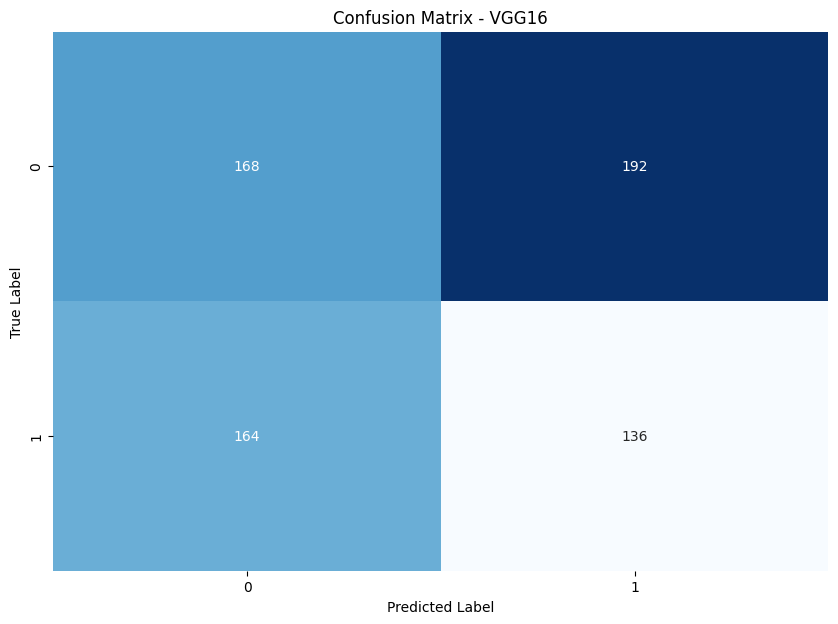

VGG19 Model Confusion Matrix


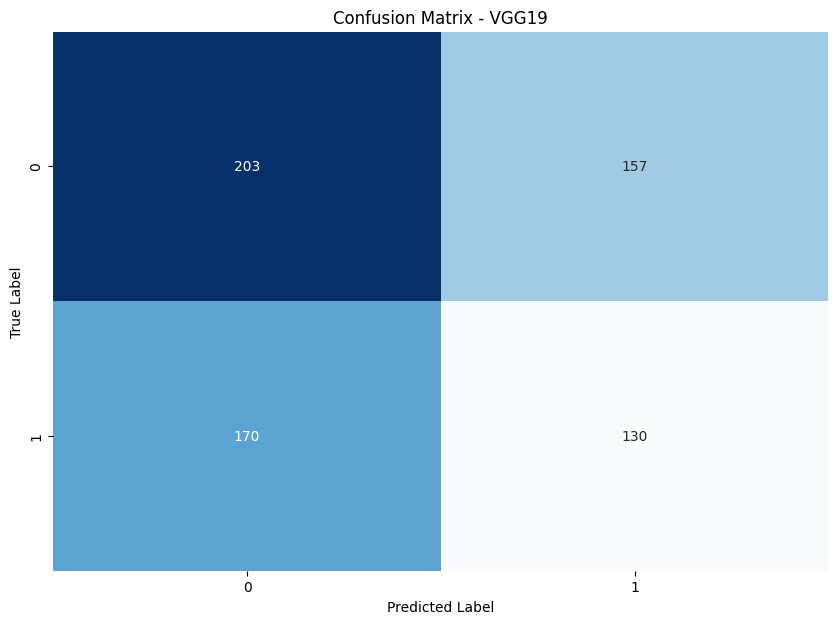

In [142]:
def plot_confusion_matrix(true_classes, predicted_classes, title='Confusion Matrix'):
    matrix = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

print("Custom CNN Model Confusion Matrix")
plot_confusion_matrix(true_classes, predicted_classes_custom_cnn, 'Confusion Matrix - Custom CNN')

print("VGG16 Model Confusion Matrix")
plot_confusion_matrix(true_classes, predicted_classes_vgg16, 'Confusion Matrix - VGG16')

print("VGG19 Model Confusion Matrix")
plot_confusion_matrix(true_classes, predicted_classes_vgg19, 'Confusion Matrix - VGG19')


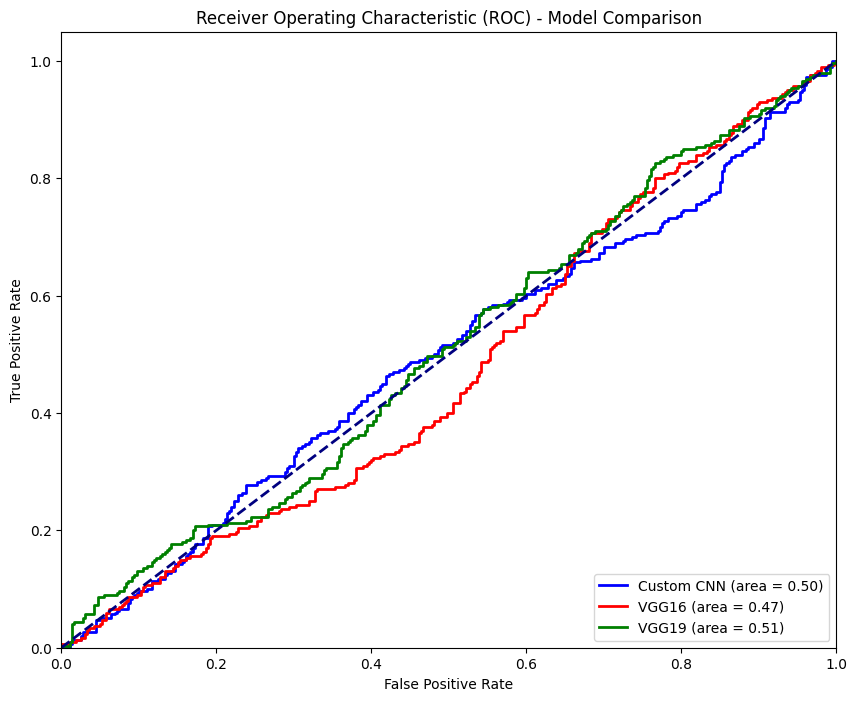

In [143]:
plt.figure(figsize=(10, 8))

plt.plot(fpr, tpr, color='blue', lw=2, label=f'Custom CNN (area = {roc_auc:.2f})')

plt.plot(fpr_vgg16, tpr_vgg16, color='red', lw=2, label=f'VGG16 (area = {roc_auc_vgg16:.2f})')

plt.plot(fpr_vgg19, tpr_vgg19, color='green', lw=2, label=f'VGG19 (area = {roc_auc_vgg19:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Model Comparison')
plt.legend(loc="lower right")
plt.show()